<center>Progetto realizzato da Elena Curti (matr. 185431)

# Sentiment analysis – Amazon reviews
</center>

## Introduzione
L'obiettivo del progetto proposto è di creare un classificatore per fare sentiment analysis su un insieme di recensioni di Amazon. Partendo da una prima versione del classificatore, esso verrà gradualmente modificato con l'obiettivo di migliorarne l'accuratezza.  <br>


## Requisiti
Questo progetto è stato realizzato con Python 3.11. E' necessaria l'installazione di MongoDB e dei seguenti pacchetti python:

In [1]:
# !pip install happiestfuntokenizing xgboost spacy
# !python -m spacy download en_core_web_s

## Operazioni iniziali
Uso il seguente script per collegarmi al database con le recensioni:

In [2]:
from pymongo import MongoClient

client = MongoClient('192.168.202.128', 27017)      # TODO mettere localhost
DATABASE = client.test
dizionario_plot = {}

Creo una classe usata per nascondere le print di alcune funzioni:

In [3]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

Creo due funzioni che verranno usate nel seguito per:
- Recuperare le recensioni dal database
- Trovare il classificatore e la relativa accuracy media (facendo 50 run)

In [4]:
import nltk, random
from nltk.sentiment.util import mark_negation, extract_unigram_feats
from nltk.sentiment.sentiment_analyzer import SentimentAnalyzer
from nltk.classify import NaiveBayesClassifier

# TODO metti 50 run
NUM_RUN = 1
REVIEWS_PER_CLASSE = 1000
REVIEWS_PER_CLASSE_TEST = 100

def getReviewData(lista_overall,  field="reviewText", funzione_tokenize=None):
    """ 
    Questa funzione ritorna una lista di tuple (rec, classe) dove rec è la recensione e classe è la classificazione (es. 1.0 o 5.0).
        - lista_overall è la lista delle classi (campo overall delle review)
        - field è il campo della review che si vuole ottenere
        - funzione_tokenize è la funzione usata per tokenizzare il testo della review. Se non dato, la lista ritornata conterra' il contenuto del campo field
    """
    reviews = []
    for overall in lista_overall:
        # for review in DATABASE.reviews.find({"overall": overall}).limit(REVIEWS_PER_CLASSE):
        for review in DATABASE.reviews.aggregate([
            { '$match' :{"overall": overall}},  
            { '$match': { '$expr': { '$lt': [0.5, {'$rand': {} } ] } } },   # Prendo le reviews in modo random ogni volta
            { '$limit' : REVIEWS_PER_CLASSE}]):
            if funzione_tokenize == None:
                reviews.append((review[field],str(overall))) 
            else:
                reviews.append(([str(i).lower() for i in funzione_tokenize(review[field])],str(overall))) 
            
    random.shuffle(reviews) 
    return reviews 

def get_classifier_and_mean_accuracy(lista_overall, funzione_filtra_reviews=lambda x:x, feat_extractor=None,  **kwargs):
    """
    Questa funzione ritorna il classifier e la relativa accuracy media.  
        - lista_overall è la lista delle classi (campo overall delle review)
        - funzione_filtra_reviews è una funzione che viene chiamata per cambiare le reviews da esaminare. 
          funzione_filtra_reviews prende in ingresso le reviews estratte (lista di tuple (rec, classe)). 
          funzione_filtra_reviews può poi, ad esempio, selezionare solo alcune parole (es. solo gli aggettivi) dai testi delle recensioni.
          Infine, essa deve ritornare le reviews modificate.
        - feat_extractor è una funzione che viene usata nell'add_feat_extractor del sentiment analyzer. 
          Se omessa, viene usata extract_unigram_feats. 
          Altrimenti, feat_extractor deve essere una funzione che prende in input i soli documenti
        - i restanti parametri opzionali saranno dati in input a getReviewData
    """

    # Run dei test e accuracy
    accuracy = []

    for i in range(NUM_RUN):
        # Prendo le reviews
        reviews = getReviewData(lista_overall, **kwargs)
        reviews = funzione_filtra_reviews(reviews)
        
        # Sentiment analyzer e applicazione delle feature
        sentimAnalyzer = SentimentAnalyzer() 

        if feat_extractor == None:
            allWordsNeg = sentimAnalyzer.all_words([mark_negation(doc) for doc in reviews])    
            unigramFeats = sentimAnalyzer.unigram_word_feats(allWordsNeg, min_freq=4)   
            sentimAnalyzer.add_feat_extractor(extract_unigram_feats, unigrams=unigramFeats)
        else:
            sentimAnalyzer.add_feat_extractor(feat_extractor)

        featureSets = sentimAnalyzer.apply_features(reviews)
        trainSet, testSet = featureSets[REVIEWS_PER_CLASSE_TEST:], featureSets[:REVIEWS_PER_CLASSE_TEST]

        # Classificatore e accuracy
        with HiddenPrints(): 
            classifier = sentimAnalyzer.train(NaiveBayesClassifier.train, trainSet)
            evalu = sentimAnalyzer.evaluate(testSet)

        accuracy.append(evalu["Accuracy"])

    return classifier, round(sum(accuracy)/len(accuracy), 4) 

## Versione 1 (originale): Word tokenizer di nltk con due classi
Per questa prima versione:
- recupero il campo "reviewText" delle recensioni positive (5 stelle) e negative (1 stella)
- uso la funzione  ```word_tokenize``` fornita da nltk per tokenizzarne il campo
- uso come feature la word occurrency
- trovo il classificatore e l'accuracy media

In [5]:
classifier1, accuracy1 = get_classifier_and_mean_accuracy([1.0, 5.0], funzione_tokenize=nltk.word_tokenize)
print("Accuracy:", accuracy1)
dizionario_plot["1.Originale"] = accuracy1

Accuracy: 0.8604


Abbiamo ottenuto una buona accuracy. Proviamo a vedere quali parole sono state le più significative per il classificatore:

In [6]:
classifier1.show_most_informative_features()

Most Informative Features
        contains(bosses) = True              5.0 : 1.0    =     15.6 : 1.0
      contains(horrible) = True              1.0 : 5.0    =     14.5 : 1.0
          contains(paid) = True              1.0 : 5.0    =     14.4 : 1.0
         contains(worse) = True              1.0 : 5.0    =     13.1 : 1.0
        contains(brings) = True              5.0 : 1.0    =     12.9 : 1.0
        contains(plenty) = True              5.0 : 1.0    =     12.3 : 1.0
        contains(poorly) = True              1.0 : 5.0    =     11.7 : 1.0
          contains(sent) = True              1.0 : 5.0    =     11.4 : 1.0
         contains(waste) = True              1.0 : 5.0    =     11.3 : 1.0
       contains(garbage) = True              1.0 : 5.0    =     11.0 : 1.0


Come facilmente intuibile, se una recensione contiene parole negative (es. waste, horrible) sarà più probabilmente negativa. Stessa cosa vale per le parole positive.

## Versione 2: Sentiment tokenizer di Christopher Potts con due classi
Provo ora a modificare la versione precedente usando con la funzione ```tokenize``` di Christopher Potts al posto di ```nltk.word_tokenize```:

In [7]:
from happiestfuntokenizing.happiestfuntokenizing import Tokenizer
classifier2, accuracy2 = get_classifier_and_mean_accuracy([1.0, 5.0], funzione_tokenize=Tokenizer().tokenize)
print("Accuracy:", accuracy2)
dizionario_plot["2.ChrisPott"] = accuracy2

Accuracy: 0.8548


Questa volta abbiamo ottenuto una accuracy peggiore (la differenza tra le due è comunque minima). Di nuovo, stampo le features più significative nelle reviews:

In [8]:
classifier2.show_most_informative_features()

Most Informative Features
       contains(ocarina) = True              5.0 : 1.0    =     20.7 : 1.0
         contains(waste) = True              1.0 : 5.0    =     17.0 : 1.0
         contains(awful) = True              1.0 : 5.0    =     15.4 : 1.0
      contains(terrible) = True              1.0 : 5.0    =     14.7 : 1.0
          contains(bugs) = True              1.0 : 5.0    =     14.1 : 1.0
       contains(useless) = True              1.0 : 5.0    =     14.1 : 1.0
        contains(legend) = True              5.0 : 1.0    =     13.9 : 1.0
         contains(worst) = True              1.0 : 5.0    =     13.5 : 1.0
          contains(paid) = True              1.0 : 5.0    =     13.4 : 1.0
       contains(support) = True              1.0 : 5.0    =     11.6 : 1.0


Notiamo subito che non c'è molta differenza tra le parole estratte in questa versione e nella precedente. In entrambi i casi, le features più significative sono le parole negative o positive. Questo è probabilmente il motivo per cui i due classificatori hanno un'accuracy molto simile.

## Versione 3: Classificazione a cinque classi
Proverò questa volta ad aggiungere anche le recensioni con 2, 3 e 4 stelle:

In [9]:
classifier3, accuracy3 = get_classifier_and_mean_accuracy([float(i) for i in range(1,6)], funzione_tokenize=nltk.word_tokenize)
print("Accuracy:", accuracy3)
dizionario_plot["3.Cinque classi"] = accuracy3

Accuracy: 0.412


Come ci si poteva aspettare, l'accuracy è drasticamente peggiorata. Infatti, il classificatore farà sicuramente più fatica a classificare una recensione con parole positive, perché essa potrebbe essere sia a 4 che a 5 stelle. Vale lo stesso per una recensione con parole negative.

In [10]:
classifier3.show_most_informative_features()

Most Informative Features
       contains(ocarina) = True              5.0 : 3.0    =     23.0 : 1.0
          contains(kart) = True              5.0 : 2.0    =     17.2 : 1.0
         contains(modes) = True              4.0 : 1.0    =     15.6 : 1.0
          contains(paid) = True              1.0 : 5.0    =     15.0 : 1.0
         contains(worse) = True              2.0 : 5.0    =     14.1 : 1.0
        contains(bosses) = True              5.0 : 1.0    =     13.7 : 1.0
      contains(memories) = True              5.0 : 1.0    =     13.7 : 1.0
       contains(zombies) = True              4.0 : 1.0    =     13.6 : 1.0
          contains(bond) = True              5.0 : 1.0    =     13.0 : 1.0
        contains(tekken) = True              4.0 : 1.0    =     12.9 : 1.0


A differenza dei precedenti classificatori, questa volta tra le feature più significative, sono presenti anche parole neutre (es. <i>park</i> o <i>wii</i>). Anche per questo motivo probabilmente il classificatore sbaglia a classificare le recensioni. <br>
Non avendo migliorato l'accuracy, nel seguito continuerò ad usare le sole recensioni a cinque e a una stella.

## Cambio delle feature
Fin ora ho sempre considerato come feature la presenza (word occurrency) delle parole tokenizzate del field "reviewText" delle recensioni. Proverò in questo paragrafo a cambiare le features estratte, per cercare di aumentare l'accuracy del classificatore.

### Versione 4: Uso del field "summary"
Nelle reviews è presente un campo "summary" contenente poche parole che riassumono il testo della recensione. Proverò quindi ad usare questo invece dell'intero testo:

In [11]:
classifier4, accuracy4 = get_classifier_and_mean_accuracy([1.0, 5.0], field="summary", funzione_tokenize=nltk.word_tokenize)
print("Accuracy:", accuracy4)
dizionario_plot["4.Summary"] = accuracy4

Accuracy: 0.8


In [12]:
classifier4.show_most_informative_features()

Most Informative Features
          contains(best) = True              5.0 : 1.0    =     26.4 : 1.0
       contains(awesome) = True              5.0 : 1.0    =     22.9 : 1.0
         contains(zelda) = True              5.0 : 1.0    =     14.3 : 1.0
       contains(classic) = True              5.0 : 1.0    =     13.7 : 1.0
           contains(not) = True              1.0 : 5.0    =     13.2 : 1.0
         contains(works) = True              5.0 : 1.0    =     12.1 : 1.0
         contains(great) = True              5.0 : 1.0    =     10.5 : 1.0
            contains(do) = True              1.0 : 5.0    =      8.6 : 1.0
           contains(wii) = True              5.0 : 1.0    =      8.3 : 1.0
         contains(first) = True              5.0 : 1.0    =      7.6 : 1.0


Anche in questo caso l'accuracy è leggermente peggiorata rispetto alla versione originale. Questo probabilmente perché il summary potrebbe non essere significativo rispetto all'intero testo. Esempio: esiste una recensione con summary <i>"Lana's opinion"</i> e reviewText <i>"Gift for my granddaughter.  Likes the game a lot, but prefers to just listen to the music & sounds.  We use it at my house on a separate computer (just for Lana).  Money well spent--provides hours of amusement & education"</i>

### Versione 5: uso dei soli aggettivi
Provo questa volta a selezionare dai testi delle recensioni solo gli aggettivi:

In [13]:
from nltk.corpus import wordnet as wn

def filtra_solo_aggettivi(reviews):
    new_reviews = []
    for (lista_parole,classe) in reviews:
        solo_aggettivi = []
        for par in lista_parole:
            tmp = wn.synsets(par)
            if len(tmp) > 0 and tmp[0].pos() == "a":
                solo_aggettivi.append(par)
        if solo_aggettivi != []:
            new_reviews.append((solo_aggettivi,classe)) 
    return new_reviews

classifier5, accuracy5 = get_classifier_and_mean_accuracy([1.0, 5.0], funzione_tokenize=nltk.word_tokenize, funzione_filtra_reviews=filtra_solo_aggettivi)
print("Accuracy:", accuracy5)
dizionario_plot["5.Solo aggettivi"] = accuracy5

Accuracy: 0.52


In [14]:
classifier5.show_most_informative_features()

Most Informative Features
        contains(unable) = True              1.0 : 5.0    =      8.5 : 1.0
     contains(addictive) = True              5.0 : 1.0    =      7.4 : 1.0
        contains(harder) = True              5.0 : 1.0    =      7.4 : 1.0
       contains(useless) = True              1.0 : 5.0    =      4.7 : 1.0
     contains(dangerous) = True              5.0 : 1.0    =      4.6 : 1.0
       contains(popular) = True              5.0 : 1.0    =      4.6 : 1.0
   contains(traditional) = True              5.0 : 1.0    =      4.6 : 1.0
           contains(hot) = True              5.0 : 1.0    =      4.5 : 1.0
        contains(unlike) = True              5.0 : 1.0    =      4.2 : 1.0
    contains(incredible) = True              5.0 : 1.0    =      4.1 : 1.0


L'accuracy è peggiorata, quindi è necessaria anche l'inclusione di altre parole (sostantivi, verbi, ...) per ottenere una buona accuracy.

### Versione 6: uso della word frequency 
Proviamo questa volta ad usare come feature la frequenza delle parole, invece che la sola presenza:

In [15]:
def conta_parole(words):
    wfreq=[words.count(w) for w in words]
    return dict(zip(words,wfreq))

classifier6, accuracy6 = get_classifier_and_mean_accuracy([1.0, 5.0], funzione_tokenize=nltk.word_tokenize, feat_extractor=conta_parole)
print("Accuracy:", accuracy6)
dizionario_plot["6.Frequency word"] = accuracy6

Accuracy: 0.88


In [16]:
classifier6.show_most_informative_features()

Most Informative Features
                   great = 2                 5.0 : 1.0    =     16.2 : 1.0
                   money = 2                 1.0 : 5.0    =     15.1 : 1.0
                   waste = 1                 1.0 : 5.0    =     15.1 : 1.0
                 amazing = 1                 5.0 : 1.0    =     13.6 : 1.0
                    work = 2                 1.0 : 5.0    =     13.1 : 1.0
                 ocarina = 1                 5.0 : 1.0    =     12.9 : 1.0
                   didnt = 1                 1.0 : 5.0    =     12.4 : 1.0
                terrible = 1                 1.0 : 5.0    =     12.2 : 1.0
                   mario = 2                 5.0 : 1.0    =     12.2 : 1.0
                  plenty = 1                 5.0 : 1.0    =     12.2 : 1.0


In questo caso l'accuracy è leggermente migliorata. Come si può vedere, infatti, alcune feature significative riguardano parole che compaiono più volte nel testo (es. love). 
Nel seguito, quindi, userò la word frequency.

## Lemmatize invece di tokenize
Analizzando le precedenti feature significative, si può notare che alcune parole come worst e worse derivano entrambe da bad. Se quindi la presenza di <i>worst</i> è una feature significativa per le recensioni della classe negativa (1 stella), allora probabilmente anche la presenza di <i>bad</i> lo sarà. <BR>
Per implementare ciò, ho usato le funzioni per lemmatizzare il testo, invece che tokenizzarlo. Ho inoltre rimosso le stop words perchè la loro presenza è inutile nel feature set.

### Versione 7: WordNetLemmatizer
Testo inizialmente il lemmatizer WordNetLemmatizer di nltk.

In [17]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re

stop_words = sorted(stopwords.words('english'))
wnl = WordNetLemmatizer()

def filtra_non_stop_words(reviews):
    reviews = [([wnl.lemmatize(parola) for parola in rec if parola not in stop_words], classe) for (rec,classe) in reviews]
    return reviews
    
classifier7, accuracy7 = get_classifier_and_mean_accuracy([1.0, 5.0], funzione_tokenize=nltk.word_tokenize,  funzione_filtra_reviews=filtra_non_stop_words, feat_extractor=conta_parole)
print("Accuracy:", accuracy7)
dizionario_plot["7.WordNetLemmatizer"] = accuracy7

Accuracy: 0.93


In [18]:
classifier7.show_most_informative_features()

Most Informative Features
                   waste = 1                 1.0 : 5.0    =     17.6 : 1.0
                    joke = 1                 1.0 : 5.0    =     16.6 : 1.0
                   worse = 1                 1.0 : 5.0    =     15.2 : 1.0
                  legend = 1                 5.0 : 1.0    =     14.1 : 1.0
                    best = 2                 5.0 : 1.0    =     13.4 : 1.0
                    boss = 1                 5.0 : 1.0    =     12.2 : 1.0
                    paid = 1                 1.0 : 5.0    =     11.8 : 1.0
              compatible = 1                 1.0 : 5.0    =     11.8 : 1.0
                happened = 1                 1.0 : 5.0    =     11.2 : 1.0
          disappointment = 1                 1.0 : 5.0    =     11.2 : 1.0


### Versione 8: Spacy
Provo adesso il lemmatizer di spacy.

In [19]:
import spacy

nlp = spacy.load("en_core_web_sm")

def spacy_lemmatizer(reviews):    
    new_reviews = []
    for (testo, classe) in reviews:
        doc = nlp(testo)
        lemmas = [token.lemma_ for token in doc if token.lemma_ not in stop_words] 
        new_reviews.append((lemmas, classe))    
    return new_reviews
    
classifier8, accuracy8 = get_classifier_and_mean_accuracy([1.0, 5.0],funzione_filtra_reviews=spacy_lemmatizer, feat_extractor=conta_parole)
print("Accuracy:", accuracy8)
dizionario_plot["8.Spacy"] = accuracy8

Accuracy: 0.88


In [20]:
classifier8.show_most_informative_features()

Most Informative Features
               complaint = 1                 5.0 : 1.0    =     14.6 : 1.0
                  window = 1                 1.0 : 5.0    =     14.1 : 1.0
               perfectly = 1                 5.0 : 1.0    =     14.1 : 1.0
                  poorly = 1                 1.0 : 5.0    =     12.8 : 1.0
                   waste = 1                 1.0 : 5.0    =     11.2 : 1.0
                     bad = 3                 1.0 : 5.0    =     10.8 : 1.0
                  plenty = 1                 5.0 : 1.0    =      9.9 : 1.0
                 garbage = 1                 1.0 : 5.0    =      9.5 : 1.0
                   stink = 1                 1.0 : 5.0    =      9.5 : 1.0
          disappointment = 1                 1.0 : 5.0    =      8.8 : 1.0


L'accuracy dei due lemmatizer è molto simile ma è peggiorata rispetto a quella originale.

### Versione 9: lemmatize e opinion_lexicon
Infine, ho integrato le due librerie nltk e Spacy. Ho deciso di:
- rimuovere la punteggiatura dal testo delle recensioni e rimpiazzarla con uno spazio. Analizzando le feature estratte nelle versioni precedenti, infatti, ho notato che alcune parole non venivano correttamente tokenizzate/lemmatizzate. Ad esempio "game.I" non veniva divisa in ["game", "I"]. Ho quindi implementato questa modifica per risolvere il problema. 
- memorizzare come documento la lista di parole più importanti (ad esempio i verbi, i nomi, gli avverbi, gli aggettivi) ed escludendo quindi le stop word
- selezionare solo le parole positive o negative. Per fare ciò ho usato le funzioni negative() e positive() fornite da opinion_lexicon (nltk.corpus). In questo modo vado ad eliminare le parole neutre che comunque probabilmente non mi diranno niente di utile sulle recensioni.
<!-- - rimuovere i duplicati dalla lista delle parole -->

In [21]:
from string import punctuation
from nltk.corpus import opinion_lexicon

nlp = spacy.load("en_core_web_sm")

neg_words = sorted(opinion_lexicon.negative())
pos_word = sorted(opinion_lexicon.positive())
pos_tag = {'VERB','NOUN','ADV', 'ADJ'}  

def get_keywords_in_text(text):
    for punteggiatura in punctuation:
        text = text.replace(punteggiatura, " ", -1)   
        
    doc = nlp(text.lower()) 
    result = [token.lemma_ for token in doc if (not token.text in stop_words ) and (token.pos_ in pos_tag)]
    # result = list(set(result))
    result = [token for token in result if (token in neg_words or token in pos_word)]
    return result

def seleziona_keyword(reviews):
    # reviews = [(get_keyword_in_text(rec), classe) for (rec, classe) in reviews]
    for i in range(len(reviews)):
        # print(i, end=" ")
        reviews[i] = (get_keywords_in_text(reviews[i][0]), reviews[i][1])
    return reviews

classifier9, accuracy9 = get_classifier_and_mean_accuracy([1.0, 5.0], funzione_filtra_reviews=seleziona_keyword, feat_extractor=conta_parole) 
print("Accuracy:", accuracy9)
dizionario_plot["9.lemmatize,opinion_lexicon"] = accuracy9


Accuracy: 0.84


In [22]:
classifier9.show_most_informative_features()

Most Informative Features
                   waste = 1                 1.0 : 5.0    =     14.8 : 1.0
                     bad = 3                 1.0 : 5.0    =     13.8 : 1.0
                 useless = 1                 1.0 : 5.0    =     13.1 : 1.0
                horrible = 1                 1.0 : 5.0    =     11.7 : 1.0
                   tough = 1                 5.0 : 1.0    =     10.9 : 1.0
            disappointed = 1                 1.0 : 5.0    =     10.7 : 1.0
               complaint = 1                 5.0 : 1.0    =     10.3 : 1.0
                 amazing = 1                 5.0 : 1.0    =     10.2 : 1.0
                    lame = 1                 1.0 : 5.0    =      9.7 : 1.0
                   awful = 1                 1.0 : 5.0    =      9.7 : 1.0


Anche in questo caso ho leggermente migliorato l'accuracy.

## Uso della libreria Scikit-learn
Proverò ora ad usare la libreria <i>Scikit-learn</I>. <br>
Creo innanzitutto una funzione che ritorni i dati e i target del train set e del test set:

In [45]:
def get_train_test_data_target(reviews):
    """
    Questa funzione ritorna: train_data, train_target, test_data e test_target delle reviews in input.
        - train_data, test_data sono i "documenti" del trainset e testset rispettivamente
        - train_target, test_target sono le classi del trainset e testset rispettivamente
    """
    classi = list(set(list({x[1] for x in reviews})))
    testSet= reviews[:REVIEWS_PER_CLASSE]  
    trainSet = reviews[REVIEWS_PER_CLASSE:]

    # # Controlli
    # classi_count = {str(c):0 for c in classi}
    # for (feat, classe) in trainSet:
    #     classi_count[classe] +=1
    # print("trainset:", classi_count)

    # classi_count = {str(c):0 for c in classi}
    # for (feat, classe) in testSet:
    #     classi_count[classe] +=1
    # print("testSet:", classi_count)

    
    train_data, train_target = list(map(list, zip(*trainSet)))
    test_data, test_target = list(map(list, zip(*testSet)))

    return train_data, train_target, test_data, test_target

### Versione 10: Classificatore Support Vector Machines (SVM)
Nelle versioni viste finora, ho sempre fatto uso del classificatore Naive Bayes di nltk. Andrò ora a modificarlo, usando il Support Vector Machines (SVM) di Scikit-learn. 
Uso inoltre la pipeline, per:
- effettuare la pre-elaborazione del testo, il tokenizing e l'eliminazione delle stopwords (mediante il CountVectorizer)
- contare le TF-IDF frequencies (usando TfidfTransformer)
- fare il train del classificatore 

Inoltre, stavolta uso cross_val_score per effettuare direttamente 50 run. 

In [46]:
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.pipeline import Pipeline

# Creo il train e test set
reviews10 = getReviewData([1.0, 5.0])
train_data, train_target, test_data, test_target = get_train_test_data_target(reviews10)

# Classificatore
text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),('clf', svm.SVC()),])
text_clf.fit(train_data, train_target)
predicted = text_clf.predict(test_data)

# Cross-validation
cv = ShuffleSplit(n_splits=NUM_RUN, test_size=0.2, random_state=0)
scores = cross_val_score(text_clf, test_data, test_target, cv=cv)
accuracy10 = round(sum(scores)/len(scores), 4)
print("Accuracy:", accuracy10)
dizionario_plot["10.SVM"] = accuracy10

Accuracy: 0.8774


### Versione 11: Hyperlane
Effettuo gli stessi passaggi di prima, ma stavolta uso il classificatore SGDClassifier.

In [47]:
from sklearn.linear_model import SGDClassifier

# Creo il train e test set
reviews11 = getReviewData([1.0, 5.0])
train_data, train_target, test_data, test_target = get_train_test_data_target(reviews11)

# Classificatore
text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)),])
text_clf.fit(train_data, train_target)
predicted = text_clf.predict(test_data)

# Cross-validation
cv = ShuffleSplit(n_splits=NUM_RUN, test_size=0.2, random_state=0)
scores = cross_val_score(text_clf, test_data, test_target, cv=cv)
accuracy11 = round(sum(scores)/len(scores), 4)
print("Accuracy:", accuracy11)
dizionario_plot["11.Hyperlane"] = accuracy11


Accuracy: 0.8742


### Versione 12: Grid-search
Proverò stavolta a usare la grid search (GridSearchCV) di sklearn.

In [48]:
from sklearn.model_selection import GridSearchCV

reviews12 = getReviewData([1.0, 5.0])
train_data, train_target, test_data, test_target = get_train_test_data_target(reviews12)

text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])
text_clf.fit(train_data, train_target)

parameters = {'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False), 'clf__alpha': (1e-2, 1e-3),}
cv = ShuffleSplit(n_splits=NUM_RUN, test_size=0.2, random_state=0)

gs_clf = GridSearchCV(text_clf, parameters, cv=cv, n_jobs=-1)
gs_clf.fit(train_data, train_target)
predicted = gs_clf.predict(test_data)

scores = cross_val_score(text_clf, test_data, test_target, cv=cv)
accuracy12 = round(sum(scores)/len(scores), 4)

print("Accuracy: ", accuracy12)
dizionario_plot["12.Grid-search"] = accuracy12


Accuracy:  0.8882


## Versione 13: Uso di XGBoost
Proverò infine a usare la ibreria XGBoost 

In [49]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import accuracy_score

accuracy13 = []
for _ in range(NUM_RUN):
    reviews13 = getReviewData([1.0, 5.0])
    train_data, train_target, test_data, test_target = get_train_test_data_target(reviews13)

    cv = CountVectorizer(binary = True)
    cv.fit(train_data, train_target)
    train_transform = cv.transform(train_data)
    test_transform = cv.transform(test_data)

    # Trasformo i target del trainset e testset in un formato adatto a xgboost
    train_target = [0 if target=="1.0" else 1 for target in train_target]
    test_target = [0 if target=="1.0" else 1 for target in test_target]

    # Training and Predicting
    train_matrix = xgb.DMatrix(train_transform, train_target)      
    test_matrix = xgb.DMatrix(test_transform, test_target)

    param = {'objective': 'binary:hinge'}       # Mette in  predicted_test solo valori 0 o 1 
    classifier13 = xgb.train(param, train_matrix, num_boost_round = 30)
    predicted_test = classifier13.predict(test_matrix).tolist()

    # Accuracy
    accuracy13 += [accuracy_score(test_target, predicted_test)]

accuracy13 = round(sum(accuracy13)/len(accuracy13), 4)
print("Accuracy:",  accuracy13)
dizionario_plot["13.Xgboost"] = accuracy13

Accuracy: 0.7902


## Risultati e conclusioni
Vado ora ad analizzare le accuracy ottenute:

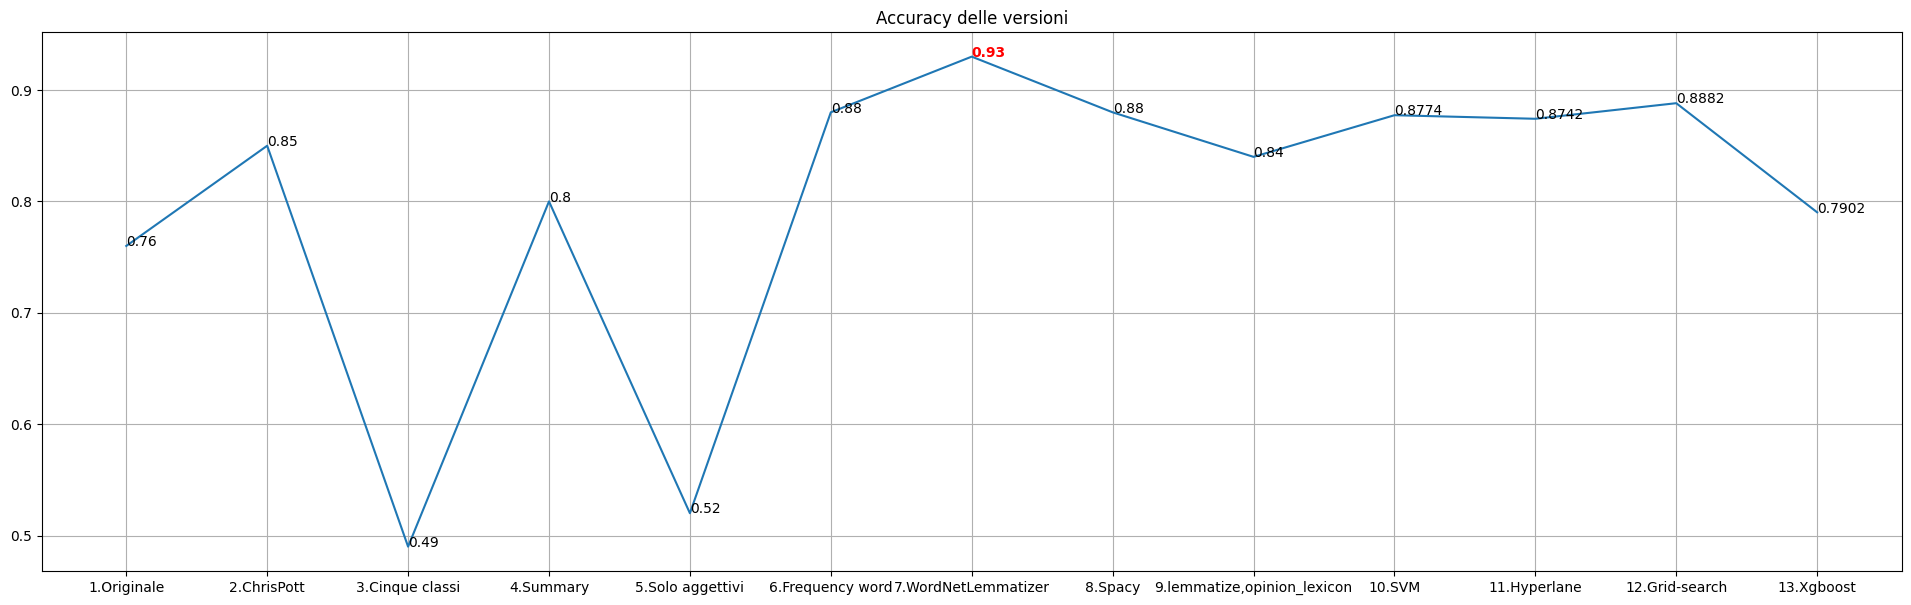

In [50]:
import matplotlib.pyplot as plt

x_titoli , y_accuracy = list(dizionario_plot.keys()), list(dizionario_plot.values())
plt.rcParams["figure.figsize"] = (24,7)

plt.plot(x_titoli, y_accuracy)
for i in range(len(x_titoli)):
    if y_accuracy[i] == max(y_accuracy):
        plt.text(x_titoli[i], y_accuracy[i], str(y_accuracy[i]), color="red", weight='bold')
    else:
        plt.text(x_titoli[i], y_accuracy[i], str(y_accuracy[i]))

plt.title('Accuracy delle versioni')
plt.grid()


Sono riuscita a migliorare leggermente l'accuracy del classificatore. I classificatori che hanno restituito i migliori risultati sono: